In [ ]:
!pip install transformers datasets --quiet
!pip install -U scikit-learn


In [ ]:
import pandas as pd

# Load and clean
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df = df[['text', 'label']]
df = df.dropna().reset_index(drop=True)


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
test_dataset = SpamDataset(test_encodings, test_labels)


In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade transformers


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [ ]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maria-deepti (maria-deepti-t-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.659300
20,0.486600
30,0.357500
40,0.161300
50,0.124100
60,0.064600
70,0.027800
80,0.001700
90,0.088200
100,0.167300


TrainOutput(global_step=837, training_loss=0.04582257013241655, metrics={'train_runtime': 17076.9485, 'train_samples_per_second': 0.783, 'train_steps_per_second': 0.049, 'total_flos': 879514480304640.0, 'train_loss': 0.04582257013241655, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = test_labels

print(classification_report(y_true, y_pred, target_names=['ham', 'spam']))


              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       965
        spam       0.99      0.97      0.98       150

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115



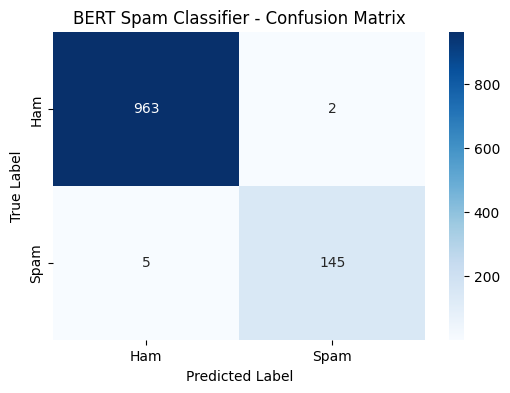

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prediction already done earlier
# y_pred = np.argmax(preds.predictions, axis=1)
# y_true = test_labels

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("BERT Spam Classifier - Confusion Matrix")
plt.show()


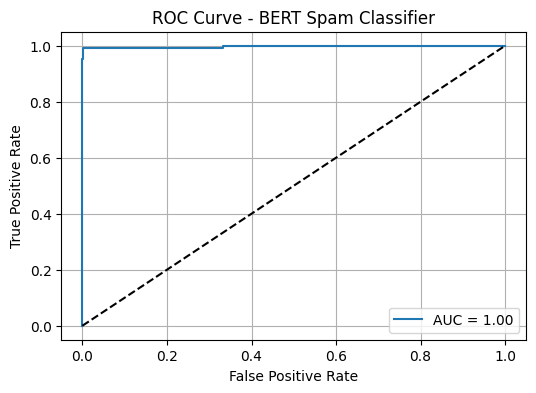

In [ ]:
from sklearn.metrics import roc_curve, auc

y_score = preds.predictions[:, 1]  # Probability of class "spam"
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT Spam Classifier')
plt.legend()
plt.grid()
plt.show()


/tmp/ipython-input-14-2138188696.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df.index[:2], y=report_df.loc[:'Spam', 'f1-score'], palette='viridis')


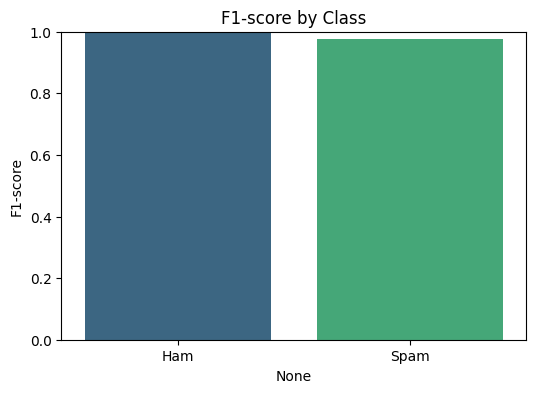

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Create classification report as dict
report = classification_report(y_true, y_pred, target_names=['Ham', 'Spam'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot F1-scores
plt.figure(figsize=(6, 4))
sns.barplot(x=report_df.index[:2], y=report_df.loc[:'Spam', 'f1-score'], palette='viridis')
plt.title("F1-score by Class")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.show()


In [ ]:
!pip install wordcloud


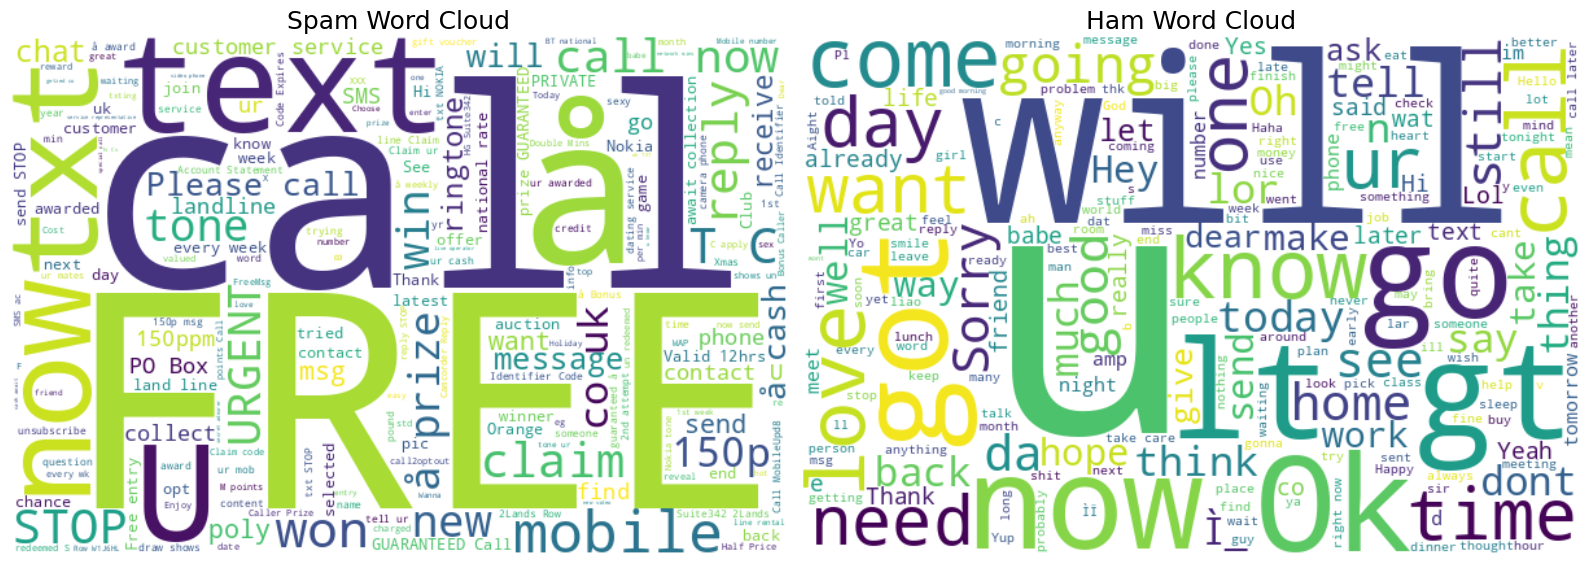

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split by label
spam_text = " ".join(df[df['label'] == 1]['text'])
ham_text = " ".join(df[df['label'] == 0]['text'])

plt.figure(figsize=(16, 8))

# Spam WordCloud
plt.subplot(1, 2, 1)
spam_wc = WordCloud(width=600, height=400, background_color='white').generate(spam_text)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Spam Word Cloud", fontsize=18)

# Ham WordCloud
plt.subplot(1, 2, 2)
ham_wc = WordCloud(width=600, height=400, background_color='white').generate(ham_text)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Ham Word Cloud", fontsize=18)

plt.tight_layout()
plt.show()


In [ ]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply sentiment
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['text'].apply(get_sentiment)

# Show example
print(df[['text', 'label', 'sentiment']].head())


                                                text  label sentiment
0  Go until jurong point, crazy.. Available only ...      0  positive
1                      Ok lar... Joking wif u oni...      0  positive
2  Free entry in 2 a wkly comp to win FA Cup fina...      1  positive
3  U dun say so early hor... U c already then say...      0   neutral
4  Nah I don't think he goes to usf, he lives aro...      0  negative


/tmp/ipython-input-19-233798468.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


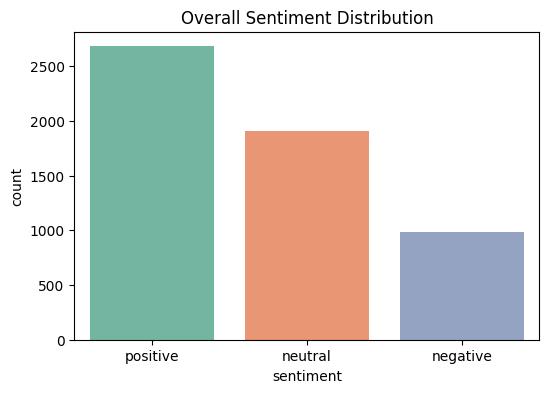

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Overall Sentiment Distribution")
plt.show()


/tmp/ipython-input-20-2950490568.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['label'] == 1], x='sentiment', palette='Reds')
/tmp/ipython-input-20-2950490568.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['label'] == 0], x='sentiment', palette='Greens')


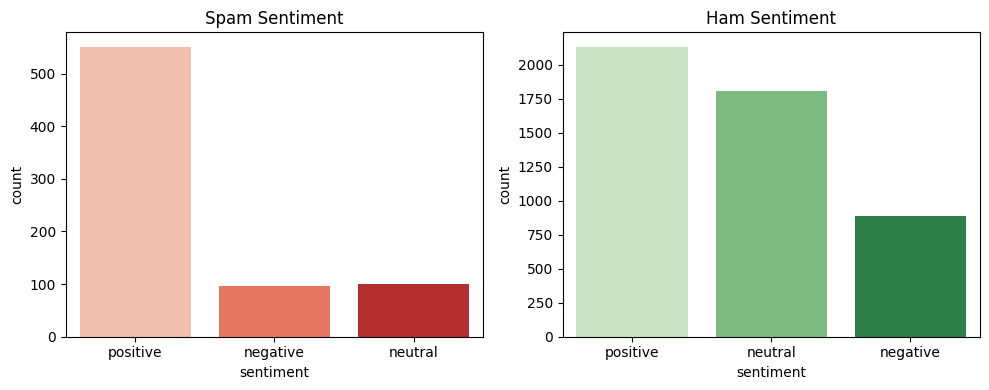

In [ ]:
plt.figure(figsize=(10, 4))

# Spam sentiment
plt.subplot(1, 2, 1)
sns.countplot(data=df[df['label'] == 1], x='sentiment', palette='Reds')
plt.title("Spam Sentiment")

# Ham sentiment
plt.subplot(1, 2, 2)
sns.countplot(data=df[df['label'] == 0], x='sentiment', palette='Greens')
plt.title("Ham Sentiment")

plt.tight_layout()
plt.show()
